Link [Colab notebook](https://colab.research.google.com/drive/11wo5OKkGbIimxb7IcawKQSrLVSqADxwJ?usp=sharing).

In [ ]:
#@title Some helper functions
%%capture
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy
import torch, torchvision
import sys

sys.setrecursionlimit(2000)

def generate_dataset(n_data, n_cluster=2, n_dim=2, ax=None):
    n_data //= n_cluster
    cent = np.arange(n_dim*n_cluster)
    np.random.shuffle(cent)
    cent = cent.reshape(1, n_cluster, n_dim)

    X = np.random.randn(n_data, n_cluster, n_dim)/1.5 + cent
    if ax and n_dim == 2:
        for i in range(n_cluster):
            ax.scatter(*X[..., i, :].transpose((-1, 0)).reshape(2, -1))
    return X.reshape(-1, n_dim)

def plot_kmean_trajectory(k_means, X):
    from sklearn.inspection import DecisionBoundaryDisplay

    feature_1, feature_2 = np.meshgrid(
        np.linspace(X[:, 0].min()-0.2, X[:, 0].max()+0.2, num=100),
        np.linspace(X[:, 1].min()-0.2, X[:, 1].max()+0.2, num=100)
    )
    grid = np.vstack([feature_1.ravel(), feature_2.ravel()]).T
    dist = np.linalg.norm(
        np.expand_dims(grid, 1) - k_means, axis=-1
    )
    ct = np.argmin(dist, axis=-1).reshape(feature_1.shape)
    display = DecisionBoundaryDisplay(
        xx0=feature_1, xx1=feature_2, response=ct
    )
    display.plot()

    dist = np.linalg.norm(
        np.expand_dims(X, 1) - k_means, axis=-1
    )
    y_pred = np.argmin(dist, axis=-1).reshape(-1)
    display.ax_.scatter(
        *X.T, edgecolor="black", c=y_pred
    )
    plt.show()

def plot_dbscan(core, border, noise, neighbor, X, dsu):
    for core_i in np.unique(dsu[core]):
        plt.scatter(*X[(dsu==core_i) * core].T, edgecolor="black")
    plt.gca().set_prop_cycle(None)
    for border_i in np.unique(dsu[core]):
        plt.scatter(*X[(dsu==border_i)*border].T,
                    alpha=0.3, edgecolor="black")
    for border_i in set(np.unique(dsu[border])) - set(np.unique(dsu[core])):
        plt.scatter(*X[(dsu==border_i)*border].T,
                    alpha=0.3, edgecolor="black")
    plt.scatter(*X[noise].T, alpha=0.3, label="noise", c='black', marker="D")
    plt.title("DBSCAN")
    plt.legend()
    plt.show()

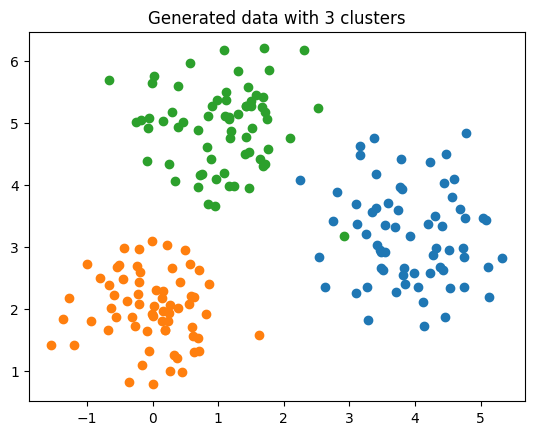

In [ ]:
fig, ax = plt.subplots()
X = generate_dataset(200, 3, ax=ax)
plt.title("Generated data with 3 clusters")
plt.show()

# K-Means Clustering
In K mean, we maintain a set of k centroid (initially random data points). Then the algorithm repeats until (hopefully) convergence. At each iteration, all the datapoints in the dataset are grouped into the cluster whose centroid is closest to them. Then the newly calculated clusters are used to update the k centroids.

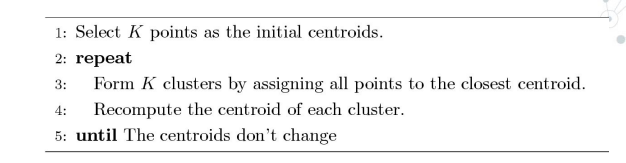

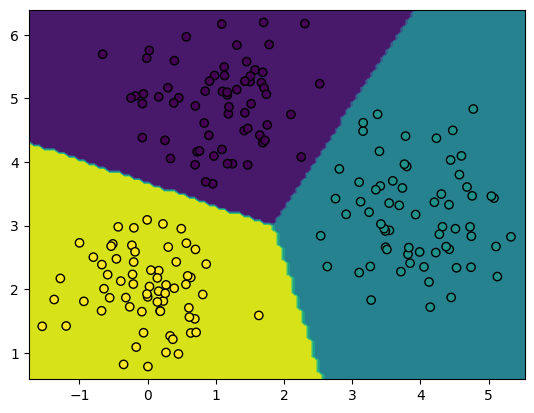

In [ ]:
#@title K-Means Implementation {vertical-output: true}
n_cluster = 3
n_dim = 2
iter = 200

k_means = np.array([random.choices(X, k=n_cluster)] ) # random init

for _ in range(iter):
    dist = np.linalg.norm(
        np.expand_dims(X, 1) - k_means, axis=-1
    )
    cluster = np.argmin(dist, axis=-1)
    for c in range(n_cluster):
        k_means[:,c] = np.mean(X[cluster == c], axis=0)

plot_kmean_trajectory(k_means, X)

/usr/local/lib/python3.10/dist-packages/sklearn/inspection/_plot/decision_boundary.py:187: UserWarning: The following kwargs were not used by contour: 'lpha'
  self.surface_ = plot_func(self.xx0, self.xx1, self.response, **kwargs)


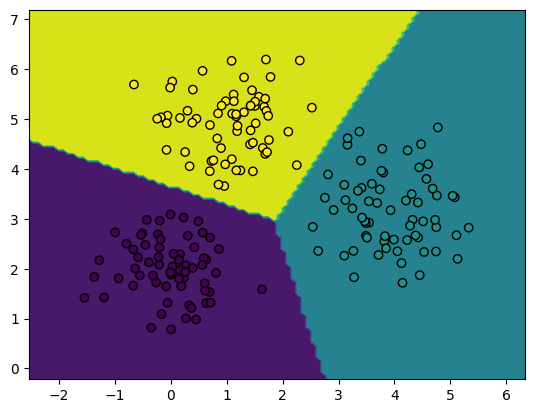

In [ ]:
#@title K-Means Sklearn {vertical-output: true}
from sklearn.cluster import KMeans
from sklearn.inspection import DecisionBoundaryDisplay

kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(X)
disp = DecisionBoundaryDisplay.from_estimator(
    kmeans, X, response_method="predict",
    lpha=0.5,
)
disp.ax_.scatter(X[:, 0], X[:, 1], c=kmeans.predict(X), edgecolor="k")
plt.show();

# DBSCAN

In [ ]:
#@title Noisy circle dataset {vertical-output: true}
from sklearn import datasets
n_samples = 2000
seed = 30

X, y = datasets.make_circles(
    n_samples=n_samples, factor=.5, noise=0.09, random_state=seed
)

In DBSCAN, there are three types of points: core points, border points and noise points. Core points are points that has at least `min_samples` neighbors (or degree). Border points are points that are not core points but connect to at least a core point. And Noise points are points that are neither core nor border.

*Note*: two points are connected (or be neighbor of each other) if their distance are less than `eps`. As such, `eps` and `min_samples` are two most important hyper-parameters to consider when using DBSCAN.

After finding which points are core. DBSCAN connects core points to form connected components, which will be clusters. For finding connected components, we use DSU algorithm.

The complexity of the algorithm will depend on two critical operations: finding neighbors and connecting core points. In the below implementation, we use brute force approach: all distance pairs are calculated, which has complexity of $O(n^2)$. More efficient data structure can be used to facilitate the search for nearest neighbors, such as kd tree. In sklearn, there is a hyperparameter that specifies which data structure to be used for finding neighbors (see `algorithm`). For DSU, efficient implementation has complexity of $O(n\alpha (n))$ with $\alpha(n)$ is the inverse Ackermann function, while the DSU implementation below has complexity of $O(n\log n)$. You can see this [link](https://cp-algorithms.com/data_structures/disjoint_set_union.html) for more information about DSU.

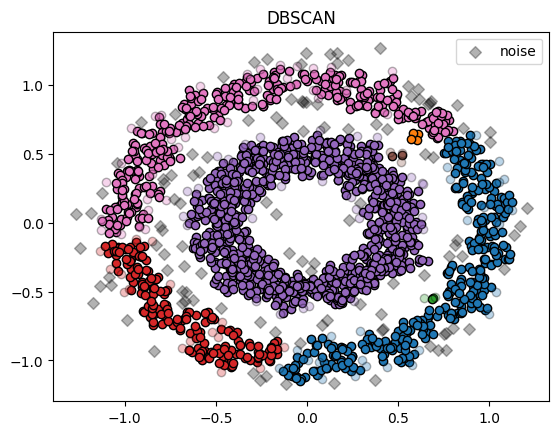

In [ ]:
#@title DBSCAN Implementation {vertical-output: false}

eps = 6e-2
min_samples = 3

dist = np.linalg.norm(
    np.expand_dims(X, 0) - np.expand_dims(X, 1), axis=-1
)

neighbor = dist < eps

# core points are points with > min_samples neighbor
core = neighbor.sum(axis=-1) > min_samples
# border points are points that connect to a core point and not a core point
border = (np.sum(neighbor * (np.ones(core[..., None].shape) @ core[..., None].T), axis=-1) > 0) ^ core
# noise points are points that are neither core nor border
noise = ~(border | core)

# DSU data structure for finding connected components
dsu = np.arange(X.shape[0])
def find_set(v):
    if v == dsu[v]:
        return v
    dsu[v] = find_set(dsu[v])
    return dsu[v]

def union_sets(a, b):
    a = find_set(a)
    b = find_set(b)
    if a != b:
        dsu[b] = a

# connect cores (both are core vertices and be neighbors of each other)
for c1, c2 in zip(*np.where((neighbor * (core[..., None] @ core[..., None].T)) == 1)):
    union_sets(c1, c2)

# connect borders to cores (one is core, one is border and are neighbors)
for b, c in zip(*np.where((neighbor * (border[..., None] @ core[..., None].T)) == 1)):
    dsu[b] = find_set(c)

# make dsu flat again :v
for i in range(X.shape[0]):
    dsu[i] = find_set(i)

plot_dbscan(core, border, noise, neighbor, X, dsu)

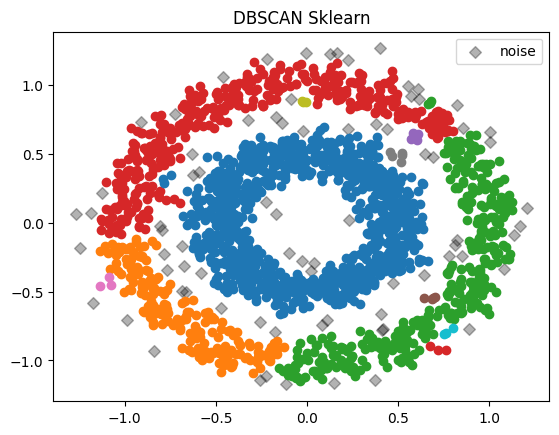

In [ ]:
#@title DBSCAN Sklearn {vertical-output: true}
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
for i in np.unique(clustering.labels_.astype(int)):
    if i == -1:
        plt.scatter(*X[clustering.labels_ == i].T, label="noise",
                    c="black", alpha=0.3, marker="D")
    else:
        plt.scatter(*X[clustering.labels_ == i].T)
plt.title("DBSCAN Sklearn")
plt.legend()
plt.show()

# PCA

We begin with a dataset containing $n$ data samples, denoted as $x_1, x_2, \dots, x_n \in \mathbb R^d$. Without imposing any specific assumptions about the data, we can only say that each of these data points resides in a vector space with $d$ dimensions. However, in reality, most real-world data exhibits underlying structure, and this structure can often be described by a relatively small number of "factors" . This is sometimes known as the [Manifold hypothesis](https://en.wikipedia.org/wiki/Manifold_hypothesis);
> *Many high-dimensional data sets that occur in the real world actually lie along low-dimensional latent manifolds inside that high-dimensional space.*

Consider a dataset containing human face images as an example. While each individual face image may be high-dimensional, most of the data can be described by a relatively smaller set of features, such as the shape of the nose, the position and appearance of the eyes, skin color, and lighting conditions, among others.
These features play a key role in capturing the essence of each face, thereby reducing the effective dimensionality of the data. This phenomenon underscores the techniques like Principal Component Analysis (PCA) in identifying and representing the underlying structure of the data.

In PCA, we want to find a linear subspace with (usually) lower dimensions than the original spaces that best described the dataset. Concretely, we want to find a linear mapping $W \in \mathbb R^{k\times d}$ that map each datapoint $x \rightarrow Wx$ to a lower dimensional representation of $x$ with $k$ dimensions. Then, a second linear mapping $U\in \mathbb R^{d \times k}$ is used to recover the $x$ as closely as possible in term of MSE loss
$$\text{arg}\min_{W, U} \sum_{i}\|x_i - UWx_i\|^2$$
If we let $y = Wx$, and $\hat{x} = Uy$, then the approximated $\hat{x} = \sum_i^k y_i \mathbf u_i$; i.e. we approximate $x$ by a linear combination of $k$ vector $\mathbf u_i$, where each $\mathbf u_i$ is a column vector of the matrix $U$. In PCA, this $k$ vectors are called principle components.

For a given (i.e. fixed) $W, U$ and an arbitrary point $x$, let $v_1, v_2, \dots, v_k$ an orthonormal basis of the range of $UW$, then the best approximation of $x$ in this subspace is the projection of $x$ onto this subspace and is calculated through the [projection matrix](https://en.wikipedia.org/wiki/Projection_matrix)
$$\hat{x} = V(V^TV)^{-1}V^Tx = VV^Tx$$
where $V \in \mathbb R^{d\times k}$ is the matrix whose columns are orthonormal basis vectors $v_1, \dots, v_k$. Then our objective is to instead find the subspaces which best approximates our dataset,
\begin{align*}
&\text{arg}\min_{V|V^TV=I} \sum_{i}\|x_i - VV^Tx_i\|^2 \\
=& \text{arg}\min_{V|V^TV=I} \sum_{i}\|x_i\|^2 - 2x_i^T VV^Tx_i + x_i^T VV^TVV^Tx_i\\
=&\text{arg}\max_{V|V^TV=I} \sum_{i}x_i^T VV^Tx_i \tag*{(this is a scalar)}\\
=& \text{arg}\max_{V|V^TV=I} \sum_{i}\text{tr}(x_i^T VV^Tx_i)\\
=& \text{arg}\max_{V|V^TV=I} \sum_{i}\text{tr}(V^Tx_ix_i^T V) \tag*{(trace is invariant to cyclic permutation)}\\
=& \text{arg}\max_{V|V^TV=I} \text{tr}\left(V^T\sum_{i}x_ix_i^T V\right)
\end{align*}
The matrix $\sum_i x_i x_i^T$ is symetric and therefore can be decomposed into the form $A=\sum_i x_i x_i^T = Q\Lambda Q^T$ (a.k.a. eigenvalue decomposition), with $Q$ matrix whose columns are eigenvectors of $A$ and $\Lambda$ the diagonal matrix whose diagonal elements are the corresponding eigenvalues. The problem is now
$$\text{tr}(V^TQ\Lambda Q^T V) = \sum_i^d \lambda_i \sum_j^k B_{i, j}^2,$$ with $B = V^TQ$ and $\lambda_i$ are the diagonal elements of $\Lambda$. Then note that the columns of $B$ are orthornormal vectors; i.e. $B^TB = Q^TVV^TQ=I$, so their row norms are [bounded by 1](https://math.stackexchange.com/questions/2638990/row-norms-of-a-tall-matrix-with-orthonormal-columns), i.e. $\sum_j B_{i, j}^2 \leq 1$. Also, the sum $\sum_i \sum_j B^2_{i, j}=k$, which is the sum of squared norms of $k$ orthornormal vectors, equals $k$. So it is obvious that we can maximize the trace by investing all $B_{i, j}$ into the largest entries of $\lambda_i$; $\sum_j B_{i, j}^2 = 1$ if $\lambda_i$ belongs to the set of $k$ largest eigenvalues. Finally, one option to realise the optimal solution is to set columns of $V$ to be $k$ eigenvectors with largest eigenvalues, in which case $\sum_j B^2_{i, j}=1$ iff $\lambda_i$ is one of the largest eigenvalues because all eigenvectors are orthorgonal to each other.

To conclude, the solution for the above optimization is to set $V$ to be the matrix whose columns are $k$ vectors corresponding to $k$ largest eigenvalues of the matrix $X^T X$.



## PCA on MNIST

In [ ]:
%%capture
import torchvision.datasets as datasets

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None).data.numpy()
mnist_shape = mnist_trainset.shape
# take random 1000 images
X = np.array(random.choices(mnist_trainset.reshape(mnist_shape[0], -1), k=1000) )
X_mean = X.mean()
X = X - X_mean

In [ ]:
A = X.T @ X
n = A.shape[0]
# find 10 largest eigenvectors of A
w, v = scipy.linalg.eigh(A, eigvals_only = False, subset_by_index=[n-10, n-1])
v = v.T[np.argsort(-w)].T # sort descending order of eigenvalues
v.shape

(784, 10)

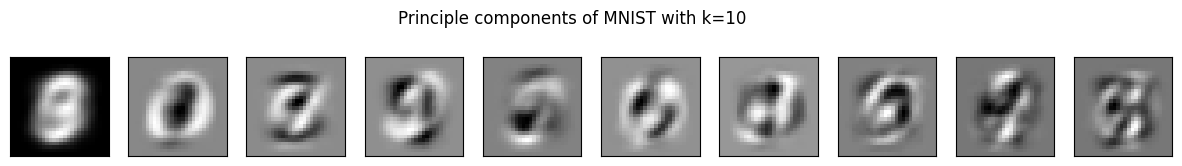

In [ ]:
#@title Visualize principle components
principle_components = v.T

fig, axs = plt.subplots(1, 10)
fig.set_figheight(2)
fig.set_figwidth(15)
fig.suptitle('Principle components of MNIST with k=10')
for i in range(10):
    pc = principle_components[i] + X_mean
    axs[i].imshow(pc.reshape(*mnist_shape[1:]), cmap="gray")
    axs[i].set_xticks([])
    axs[i].set_yticks([])


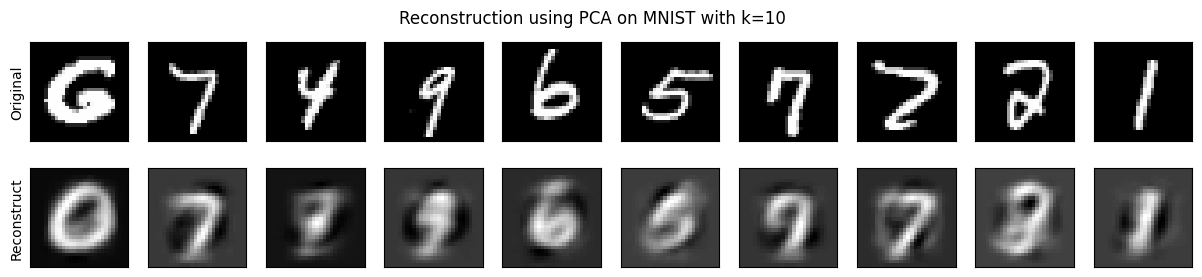

In [ ]:
#@title Reconstruction results
fig, axs = plt.subplots(2, 10)
fig.set_figheight(3)
fig.set_figwidth(15)
fig.suptitle('Reconstruction using PCA on MNIST with k=10')
for i, x in enumerate(random.choices(X, k=10)):
    reconstruct = v @ v.T @ x.T + X_mean
    x = x + X_mean
    axs[0, i].imshow(x.reshape(*mnist_shape[1:]), cmap="gray")
    axs[1, i].imshow(reconstruct.reshape(*mnist_shape[1:]), cmap="gray")
    axs[0, i].set_xticks([])
    axs[0, i].set_yticks([])
    axs[1, i].set_xticks([])
    axs[1, i].set_yticks([])
axs[0, 0].set_ylabel("Original")
axs[1, 0].set_ylabel("Reconstruct")
plt.show()

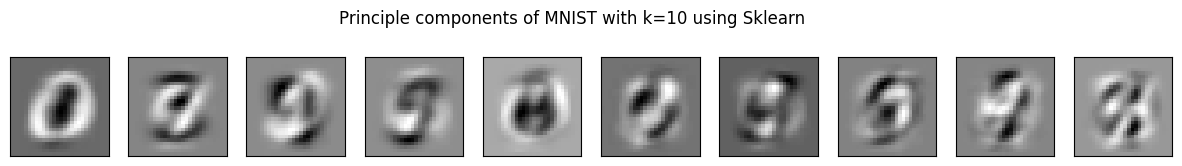

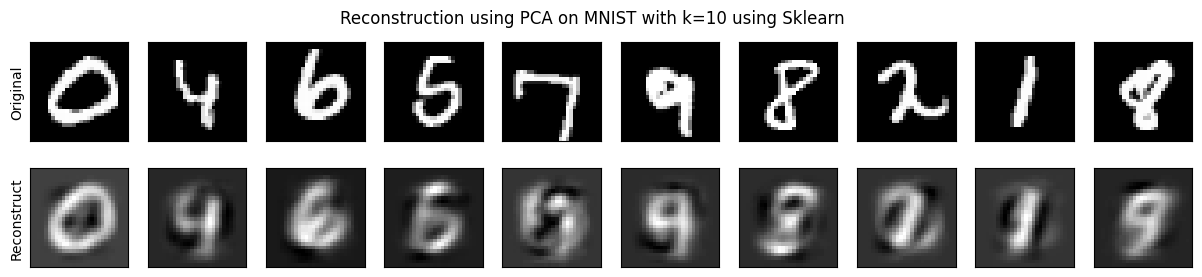

In [ ]:
#@title PCA Using Sklearn

from sklearn import decomposition
pca = decomposition.PCA(n_components=10)
pca.fit_transform(X)
principle_components = pca.components_

fig, axs = plt.subplots(1, 10)
fig.set_figheight(2)
fig.set_figwidth(15)
fig.suptitle('Principle components of MNIST with k=10 using Sklearn')
for i in range(10):
    pc = principle_components[i].reshape(*mnist_shape[1:])
    axs[i].imshow(pc, cmap="gray")
    axs[i].set_xticks([])
    axs[i].set_yticks([])
plt.show()

fig, axs = plt.subplots(2, 10)
fig.set_figheight(3)
fig.set_figwidth(15)
fig.suptitle('Reconstruction using PCA on MNIST with k=10 using Sklearn')
for i, x in enumerate(random.choices(X, k=10)):
    reconstruct = pca.inverse_transform(pca.transform(x[None, ...]))
    axs[0, i].imshow(x.reshape(*mnist_shape[1:]), cmap="gray")
    axs[1, i].imshow(reconstruct.reshape(*mnist_shape[1:]), cmap="gray")
    axs[0, i].set_xticks([])
    axs[0, i].set_yticks([])
    axs[1, i].set_xticks([])
    axs[1, i].set_yticks([])
axs[0, 0].set_ylabel("Original")
axs[1, 0].set_ylabel("Reconstruct")
plt.show()

For further reading, see the book *Understanding Machine Learning: From Theory to Algorithms* by Shai Shalev-Shwartz and Shai Ben-David, from which most of the theory in the PCA section is adapted.